In [0]:
import cv2
import numpy as np
from skimage.filters import frangi, sobel
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import moment
from google.colab.patches import cv2_imshow

import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import KFold
from keras import metrics
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.models import load_model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Część na 3.0

In [0]:
def show_image(img, title="test"):
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Wczytanie zdjęcia

In [0]:
image_size = 200
#blada gałka oczna na czarnym tle
#image = cv2.imread('zdjecia/2_good.JPG') # 11.42 / 10.99

#bardziej czerwona głka oczna na czrnym tle
#image = cv2.imread('zdjecia/8_good.JPG') # 21.93 / 21.25

#duża pomarańczowa gałka oczna na czarnym tle
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R.jpg') # 51.76 / 56.1

image = cv2.resize(image, (image_size, image_size))

gray_to_find_circle = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

## Wstępne przetworzenie obrazu

In [0]:
def thresh_show(image, th1):
    
    image2 = cv2.threshold(image, th1, 255, cv2.THRESH_BINARY)[1]
    #show_image(image2)
    
    return cv2.findContours(image2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


def contrast_image(image, low_value, high_value):
    res = [[contrast(x, low_value, high_value) for x in y] for y in image]
    return np.array(res)


def contrast(value, low, high):
    if value < low:
        return 0
    if value > high:
        return 1
    return (value - low)/(high - low)

def preparing_gray_to_find_circle(image):
  

  gray_to_find_circle = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray_to_find_circle = cv2.GaussianBlur(gray_to_find_circle, (5, 5), 0) # medianblur, guassianblur ?

  #wyostrzenie
  #obraz potrzebny do odnalezienia gałki ocznej
  kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
  gray_to_find_circle = cv2.filter2D(gray_to_find_circle, -1, kernel)

  return gray_to_find_circle

def preprocessing(image):
  #rozmycie
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  image = cv2.GaussianBlur(image, (1, 1), 0) # medianblur, guassianblur ?

  nonzero_photo = image[np.nonzero(image)]
  percentiles = np.percentile(nonzero_photo,(1, 99))
  image = contrast_image(image, percentiles[0], percentiles[1])


  return image

def main_processing(image):
  image = cv2.adaptiveThreshold((image*255).astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,15) 

  image = cv2.Laplacian(image,cv2.CV_64F)

  image = frangi(image) 
  

  return image

def find_eye_contours(gray_to_find_circle):
  # szukamy gałki ocznej
  contours, hierarchy = thresh_show(gray_to_find_circle, 0)

  contours_approved = []
  (cx, cy) , radius = (0, 0), 0
  global approxx
  maxArea = 0
  for cnt in contours:
    approx = cv2.approxPolyDP(cnt, .03 * cv2.arcLength(cnt, True), True)
    if len(approx) >= 7:
      area = cv2.contourArea(cnt)
      (cx, cy), radius = cv2.minEnclosingCircle(cnt)
      circleArea = radius * radius * np.pi
      if maxArea<area:
        contours_approved = []
        maxArea = area
        contours_approved.append(cnt)
        approxx = approx

  return contours_approved

def image_without_background(image, contours_approved):
  # wiodący obraz z konturami gałki ocznej i wypełnieniem
  image = (image*255).astype(np.uint8)

  cv2.drawContours(image, contours_approved, -1, (255, 0, 0), 3)

  rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

  fill_color = [255, 255, 255]
  mask_value = 255 

  stencil  = np.zeros(rgb.shape[:-1]).astype(np.uint8)
  cv2.fillPoly(stencil, contours_approved, mask_value)

  sel      = stencil != mask_value # select everything that is not mask_value
  rgb[sel] = fill_color            # and fill it with fill_color

  show_image(rgb, title="wiodacy obraz z konturami galki ocznej i wypelnieniem" )

  return rgb

In [0]:
def processing_image(image):

  image = cv2.resize(image, (image_size, image_size))
  show_image(image)

  gray_to_find_circle = preparing_gray_to_find_circle(image)

  image = preprocessing(image)

  image = main_processing(image)
  th = np.mean(image)
  
  contours_approved = find_eye_contours(gray_to_find_circle)
  
  image = image_without_background(image, contours_approved)

  final_image = cv2.threshold(image, th, 255, cv2.THRESH_BINARY)[1]

  return final_image

In [0]:
def short_processing_image(image):

  image = cv2.resize(image, (image_size, image_size))

  gray_to_find_circle = preparing_gray_to_find_circle(image)

  image = preprocessing(image)
  
  contours_approved = find_eye_contours(gray_to_find_circle)
  
  image = image_without_background(image, contours_approved)

  final_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  return final_image


Wczytanie i przetworzenie obrazu za pomocą funkcji

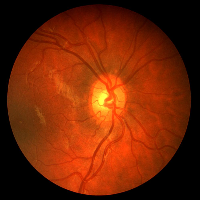

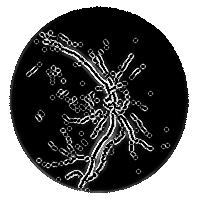

array([  0, 255], dtype=uint8)

In [17]:
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R.jpg')

image = processing_image(image)
np.unique(image)

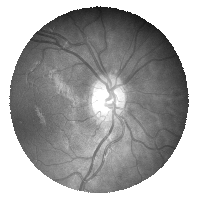

In [18]:
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R.jpg')

image = short_processing_image(image)

## Sprawdzenie

In [0]:
def process_expert_image(image):
  image = cv2.resize(image, (image_size, image_size))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret, image = cv2.threshold(image,127, 255, cv2.THRESH_BINARY)
  image = cv2.bitwise_not(image)
  return image

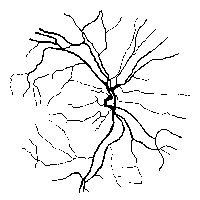

array([  0, 255], dtype=uint8)

In [20]:
expert_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R_2ndHO.png')

expert_image = process_expert_image(expert_image)

show_image(expert_image)

max_val = image_size**2

np.unique(expert_image)

In [0]:
# white == 255 == not vessel
# black == 0 == vessel


# true-positve (prawdziwie dodatnie)
# naczynie uznane jako naczynie
def count_TP(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 0) and (res_ == 0):
            i += 1
    return i

# false-positive (fałszywie dodatnie)
# nie-naczynie uznane jako naczynie
def count_FP(actually, result):
    
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 255) and (res_ == 0):
            i += 1
    return i

# false-negative (fałszywie ujemne)
# naczynie uznane jako nie-naczynie
def count_FN(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 0) and (res_ == 255):
            i += 1
    return i

# true-negative (prawdziwie ujemne)
# nie-naczynie uznane jako nie-naczynie
def count_TN(actually, result):
    i = 0
    for odp_, res_ in zip(actually, result):
        if (odp_ == 255) and (res_ == 255):
            i += 1
    return i


In [0]:
def confusion_matrix(TP, TN, FP, FN):
    names = {
        'My Results' : ['Positive', 'Negative', 'Sum'],
        'Actually - Positive' : [TP, FN, TP + FN],
        'Actually - Negative' : [FP, TN, FP + TN],
        'Sum' : [TP + FP, FN + TN, TP + FP + FN + TN]
    }
    
    df = pd.DataFrame(names, columns=['My Results', 'Actually - Positive', 'Actually - Negative', 'Sum' ]).set_index('My Results')
    return df

In [0]:
def count_quality(image, expert_image):

  TP = count_TP( np.nditer(expert_image), np.nditer(image))
  print("TP = " + str(TP/max_val))

  FP = count_FP( np.nditer(expert_image), np.nditer(image))
  print("FP = " + str(FP/max_val))

  FN = count_FN( np.nditer(expert_image), np.nditer(image))
  print("FN = " + str(FN/max_val))  

  TN = count_TN( np.nditer(expert_image), np.nditer(image))
  print("TN = " + str(TN/max_val))

  return TP, TN, FP, FN

In [86]:
TP, TN, FP, FN = count_quality(image, expert_image)
confusion_matrixx = confusion_matrix(TP, TN, FP, FN)
confusion_matrixx

TP = 0.0
FP = 0.0
FN = 0.0014
TN = 0.348225


,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,0,0,0
Negative,56,13929,13985
Sum,56,13929,13985


In [0]:
# trafność
def count_accuracy(TP, TN, FP, FN):
  return (TP + TN)/(TP + TN + FP + FN)

In [0]:
# czułość
def count_sensitivity(TP, TN, FP, FN):
  try:
    return TP/(TP + FN)
  except:
    return 1.0

In [0]:
# swoistość
def count_specificity(TP, TN, FP, FN):
  try:
    return TN/(FP + TN)
  except:
    return 1.0

In [0]:
def show_properties(TP, TN, FP, FN):
  print("Trafność: ")
  print(count_accuracy(TP, TN, FP, FN))
  print("Czułość: ")
  print(count_sensitivity(TP, TN, FP, FN))
  print("Swoistość: ")
  print(count_specificity(TP, TN, FP, FN))

In [78]:
show_properties(TP, TN, FP, FN)

Trafność: 
0.9959957096889525
Czułość: 
0.0
Swoistość: 
1.0


# Showing for 5 new images

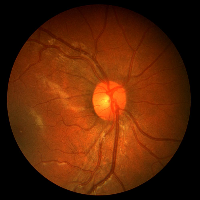

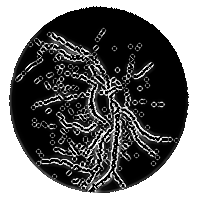

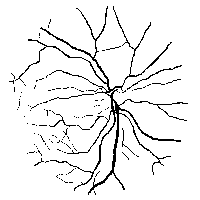

TP = 0.025925
FP = 0.3433
FN = 0.0369
TN = 0.593875
Trafność: 
0.6198
Czułość: 
0.4126541981695185
Swoistość: 
0.6336863445994612


,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,1037,13732,14769
Negative,1476,23755,25231
Sum,2513,37487,40000


In [0]:
# IMAGE 1

image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_02R.jpg')
image = processing_image(image)

expert_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_02R_2ndHO.png')
expert_image = process_expert_image(expert_image)
show_image(expert_image)

TP, TN, FP, FN = count_quality(image, expert_image)
show_properties(TP, TN, FP, FN)
confusion_matrix1 = confusion_matrix(TP, TN, FP, FN)
confusion_matrix1

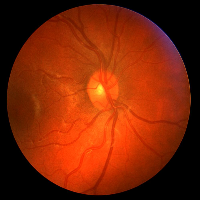

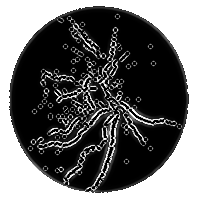

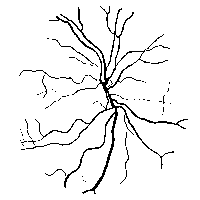

TP = 0.0187
FP = 0.309725
FN = 0.03785
TN = 0.633725
Trafność: 
0.652425
Czułość: 
0.3306808134394341
Swoistość: 
0.6717102125178864


,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,748,12389,13137
Negative,1514,25349,26863
Sum,2262,37738,40000


In [0]:
# IMAGE 2

image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_04R.jpg')
image = processing_image(image)

expert_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_04R_2ndHO.png')
expert_image = process_expert_image(expert_image)
show_image(expert_image)

TP, TN, FP, FN = count_quality(image, expert_image)
show_properties(TP, TN, FP, FN)
confusion_matrix1 = confusion_matrix(TP, TN, FP, FN)
confusion_matrix1

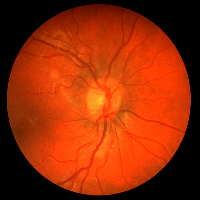

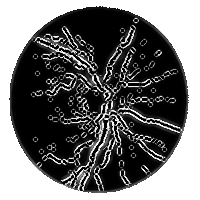

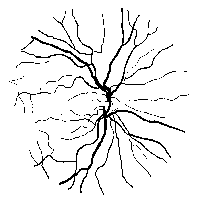

TP = 0.020725
FP = 0.23015
FN = 0.048075
TN = 0.70105
Trafność: 
0.721775
Czułość: 
0.3012354651162791
Swoistość: 
0.7528457903780069


,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,829,9206,10035
Negative,1923,28042,29965
Sum,2752,37248,40000


In [0]:
# IMAGE 3

image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_05R.jpg')
image = processing_image(image)

expert_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_05R_2ndHO.png')
expert_image = process_expert_image(expert_image)
show_image(expert_image)

TP, TN, FP, FN = count_quality(image, expert_image)
show_properties(TP, TN, FP, FN)
confusion_matrix1 = confusion_matrix(TP, TN, FP, FN)
confusion_matrix1

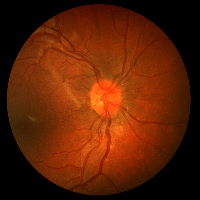

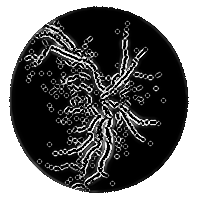

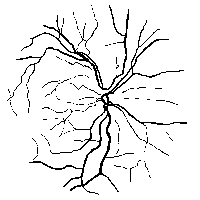

TP = 0.022175
FP = 0.255275
FN = 0.045525
TN = 0.677025
Trafność: 
0.6992
Czułość: 
0.3275480059084195
Swoistość: 
0.7261879223425936


,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,887,10211,11098
Negative,1821,27081,28902
Sum,2708,37292,40000


In [0]:
# IMAGE 4

image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_06R.jpg')
image = processing_image(image)

expert_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_06R_2ndHO.png')
expert_image = process_expert_image(expert_image)
show_image(expert_image)

TP, TN, FP, FN = count_quality(image, expert_image)
show_properties(TP, TN, FP, FN)
confusion_matrix1 = confusion_matrix(TP, TN, FP, FN)
confusion_matrix1

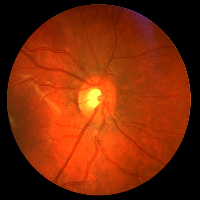

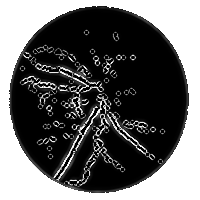

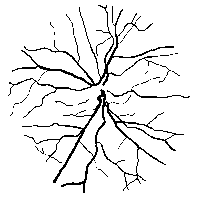

TP = 0.0296
FP = 0.32525
FN = 0.045675
TN = 0.599475
Trafność: 
0.629075
Czułość: 
0.3932248422451013
Swoistość: 
0.6482738111330395


,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,1184,13010,14194
Negative,1827,23979,25806
Sum,3011,36989,40000


In [0]:
# IMAGE 5

image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_07R.jpg')
image = processing_image(image)

expert_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_07R_2ndHO.png')
expert_image = process_expert_image(expert_image)
show_image(expert_image)

TP, TN, FP, FN = count_quality(image, expert_image)
show_properties(TP, TN, FP, FN)
confusion_matrix1 = confusion_matrix(TP, TN, FP, FN)
confusion_matrix1

# Część na 5.0

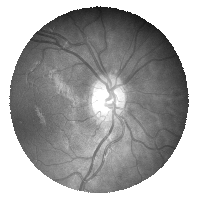

In [0]:
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R.jpg')

image = short_processing_image(image)

In [0]:
column_names = ["X", "Y", "Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance", 
               "Third central moment",
                "Right value" ]

#df = pd.DataFrame(columns = column_names)
#df

In [0]:
def workForThisSquare_full(firstCol, firstRow, image, expert_image):
    lastRow = firstRow + 5
    lastCol = firstCol + 5
    
    X = firstCol + 2
    Y = firstRow + 2
    PixelValue = image[X, Y]
    
    smallArray = image[firstRow:lastRow, firstCol:lastCol]
    
    MeanForSquare = np.mean(smallArray)
    MaxValueForSquare = np.max(smallArray)
    MinValueForSquare = np.min(smallArray)
    Variance = np.var(smallArray)
    ThirdCentralMoment = moment(smallArray, moment = 3)[0]
    
    RightValue = 0 if expert_image[X, Y] == 255 else 1
    
    
    return [X, Y, PixelValue, MeanForSquare, MaxValueForSquare, MinValueForSquare, Variance, ThirdCentralMoment,RightValue]

In [0]:
expert_image = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_03R_2ndHO.png')
expert_image = process_expert_image(expert_image)

def create_dataframe_full(image, expert_image):
  df = pd.DataFrame(columns = column_names)

  cols = image.shape[1]
  rows = image.shape[0]

  i = 0

  for c in range(0, cols - 4):
    for r in range(0, rows - 4):
      df.loc[i] = workForThisSquare_full(c, r, image, expert_image)
      i += 1
        
  for c in range(0, cols):
    for r in range(0, rows):
      if((c>1) and (c<(cols-2)) and (r>1) and (r<(rows-2))):
        pass
      else:
        RightValue = 0 if expert_image[c, r] == 255 else 1
        df.loc[i] = [c, r, image[c, r], 255, 255, 255, 0.0, 0.0,RightValue]
        i += 1

  return df


In [0]:
df = create_dataframe_full(image, expert_image)
df

,X,Y,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment,Right value
0,2.0,2.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
1,2.0,3.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
2,2.0,4.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
3,2.0,5.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
4,2.0,6.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
39995,199.0,195.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
39996,199.0,196.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
39997,199.0,197.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0
39998,199.0,198.0,255.0,255.0,255.0,255.0,0.0,0.0,0.0


In [0]:
# some data
df[df['X']==100].head(20)

,X,Y,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment,Right value
19208,100.0,2.0,255.0,255.00,255.0,255.0,0.0000,0.000,0.0
19209,100.0,3.0,255.0,255.00,255.0,255.0,0.0000,0.000,0.0
19210,100.0,4.0,255.0,245.84,255.0,26.0,2013.7344,0.000,0.0
19211,100.0,5.0,255.0,200.20,255.0,26.0,9509.9200,-1152862.944,0.0
19212,100.0,6.0,255.0,154.84,255.0,24.0,12770.2144,-584181.600,0.0
19213,100.0,7.0,255.0,109.60,255.0,24.0,11895.5200,578695.008,0.0
19214,100.0,8.0,255.0,64.84,255.0,24.0,6895.4944,1133151.504,0.0
19215,100.0,9.0,255.0,29.96,41.0,24.0,17.5584,206.400,0.0
19216,100.0,10.0,95.0,31.92,41.0,24.0,24.1536,15.600,0.0
19217,100.0,11.0,85.0,33.96,43.0,26.0,25.3184,-133.056,0.0


In [0]:
def workForThisSquare(firstCol, firstRow, image, expert_image):

  # X_cols = ["Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance", "Third central moment"]
  lastRow = firstRow + 5
  lastCol = firstCol + 5
    
  X = firstCol + 2
  Y = firstRow + 2
  PixelValue = image[X, Y]
  
  smallArray = image[firstRow:lastRow, firstCol:lastCol]
  
  MeanForSquare = np.mean(smallArray)
  MaxValueForSquare = np.max(smallArray)
  MinValueForSquare = np.min(smallArray)
  Variance = np.var(smallArray)
  ThirdCentralMoment = moment(smallArray, moment = 3)[0]
  
  return [X, Y, PixelValue, MeanForSquare, MaxValueForSquare, MinValueForSquare, Variance, ThirdCentralMoment]

In [0]:
def create_dataframe(image, expert_image, column_names):
  df = pd.DataFrame(columns = column_names)

  cols = image.shape[1]
  rows = image.shape[0]

  i = 0
  # X_cols = ["Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance", "Third central moment"]

  for c in range(0, cols - 4):
    for r in range(0, rows - 4):
      df.loc[i] = workForThisSquare(c, r, image, expert_image)
      i += 1
        
  for c in range(0, cols):
    for r in range(0, rows):
      if((c>1) and (c<(cols-2)) and (r>1) and (r<(rows-2))):
        pass
      else:
        df.loc[i] = [c, r, image[c, r], 255.0, 255, 255, 0.0, 0.0]
        i += 1

  return df

In [0]:
X_cols = ["Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance",
               "Third central moment"]
y_col = ["Right value"]

X = df[X_cols]
y = df[y_col]

np.unique(y)

In [31]:
cols = ["X", "Y", "Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance",
               "Third central moment"]

df_check = create_dataframe(image, expert_image, cols)
df_check

,X,Y,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment
0,2.0,2.0,255.0,255.0,255.0,255.0,0.0,0.0
1,2.0,3.0,255.0,255.0,255.0,255.0,0.0,0.0
2,2.0,4.0,255.0,255.0,255.0,255.0,0.0,0.0
3,2.0,5.0,255.0,255.0,255.0,255.0,0.0,0.0
4,2.0,6.0,255.0,255.0,255.0,255.0,0.0,0.0
...,...,...,...,...,...,...,...,...
39995,199.0,195.0,255.0,255.0,255.0,255.0,0.0,0.0
39996,199.0,196.0,255.0,255.0,255.0,255.0,0.0,0.0
39997,199.0,197.0,255.0,255.0,255.0,255.0,0.0,0.0
39998,199.0,198.0,255.0,255.0,255.0,255.0,0.0,0.0


In [0]:
input_shape = X.shape[1]

def build_model_v1():
    return Sequential([
        Dense(32, input_shape=(X.shape[1],), activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])



In [0]:
input_shape = X.shape[1]

def build_model_v2():
    return Sequential([
        Dense(32, input_shape=(X.shape[1],), activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.2),

        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [0]:
input_shape = X.shape[1]

def build_model_v3():
    return Sequential([
        Dense(32, input_shape=(X.shape[1],), activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dense(256, activation='relu'),
        Dropout(0.3),

        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [0]:
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)

n_split = 5

for train_index,test_index in KFold(n_split).split(X):
  x_train,x_test=X[train_index],X[test_index]
  y_train,y_test=y[train_index],y[test_index]

  model = build_model_v3()
  opt = tf.keras.optimizers.Adam(lr=0.0001)
  model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

  my_callbacks = [ EarlyStopping(patience=10, monitor='val_loss', min_delta=0, verbose=1)]
  #metrics.confusion_matrix(y_test, y_pred)
  model_history = model.fit(x_train, y_train,
          epochs=100,
          batch_size = 50,validation_split=0.20, callbacks=my_callbacks)
  
  print('Model evaluation ',model.evaluate(x_test,y_test))

Epoch 1/100
512/512 [==============================] - 2s 3ms/step - loss: 11.6150 - accuracy: 0.8978 - val_loss: 10.2207 - val_accuracy: 0.9787
Epoch 2/100
512/512 [==============================] - 1s 3ms/step - loss: 9.5157 - accuracy: 0.9114 - val_loss: 8.0401 - val_accuracy: 0.9787
Epoch 3/100
512/512 [==============================] - 1s 3ms/step - loss: 5.6169 - accuracy: 0.9139 - val_loss: 4.8050 - val_accuracy: 0.9787
Epoch 4/100
512/512 [==============================] - 2s 3ms/step - loss: 4.1355 - accuracy: 0.9173 - val_loss: 7.6418 - val_accuracy: 0.9787
Epoch 5/100
512/512 [==============================] - 1s 3ms/step - loss: 3.6300 - accuracy: 0.9210 - val_loss: 7.8257 - val_accuracy: 0.9787
Epoch 6/100
512/512 [==============================] - 1s 3ms/step - loss: 3.0019 - accuracy: 0.9197 - val_loss: 11.3547 - val_accuracy: 0.9787
Epoch 7/100
512/512 [==============================] - 1s 3ms/step - loss: 2.8613 - accuracy: 0.9200 - val_loss: 5.9102 - val_accuracy: 0.9

In [0]:
model.save("/content/drive/My Drive/Colab Notebooks/University/model_v3.h5")
print("Saved model to disk")

Saved model to disk


# Loading model

## v1

In [0]:
model = keras.models.load_model("/content/drive/My Drive/Colab Notebooks/University/model_v2.h5")

In [100]:
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_184 (Dense)            (None, 32)                224       
_________________________________________________________________
dense_185 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 128)               8320      
_________________________________________________________________
dense_187 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_188 (Dense)            (None, 32)              

# Checking results for 5 new images

Loading image 1


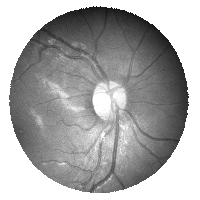

Loading image 2


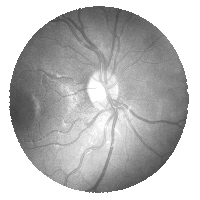

Loading image 3


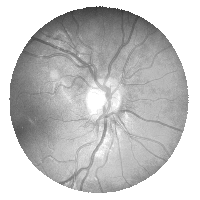

Loading image 4


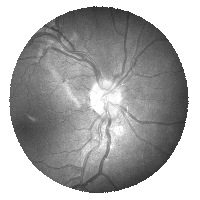

Loading image 5


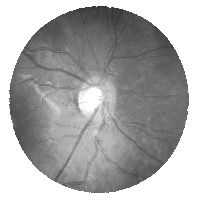

In [101]:
####### IMAGE 1 ##########
print("Loading image 1")
image1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_02R.jpg')
image1 = short_processing_image(image1)
expert1 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_02R_2ndHO.png')

######## IMAGE 2 ########
print("Loading image 2")
image2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_04R.jpg')
image2 = short_processing_image(image2)
expert2 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_04R_2ndHO.png')

######## IMAGE 3 ########
print("Loading image 3")
image3 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_05R.jpg')
image3 = short_processing_image(image3)
expert3 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_05R_2ndHO.png')

######## IMAGE 4 ########
print("Loading image 4")
image4 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_06R.jpg')
image4 = short_processing_image(image4)
expert4 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_06R_2ndHO.png')

########### IMAGE 5 #######
print("Loading image 5")
image5 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_07R.jpg')
image5 = short_processing_image(image5)
expert5 = cv2.imread('/content/drive/My Drive/Colab Notebooks/zdjecia/Image_07R_2ndHO.png')

In [102]:
df_image1 = create_dataframe(image1, expert1, cols)
df_image1

X_cols = ["Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance",
               "Third central moment"]
               
df_image1_X = df_image1[X_cols]
df_image1_X

,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment
0,255.0,255.0,255.0,255.0,0.0,0.0
1,255.0,255.0,255.0,255.0,0.0,0.0
2,255.0,255.0,255.0,255.0,0.0,0.0
3,255.0,255.0,255.0,255.0,0.0,0.0
4,255.0,255.0,255.0,255.0,0.0,0.0
...,...,...,...,...,...,...
39995,255.0,255.0,255.0,255.0,0.0,0.0
39996,255.0,255.0,255.0,255.0,0.0,0.0
39997,255.0,255.0,255.0,255.0,0.0,0.0
39998,255.0,255.0,255.0,255.0,0.0,0.0


In [0]:
def create_image(model, df_image, df_image_X):
  ynew = np.zeros(shape=(200,200))

  for i in range(len(df_image_X)):
    img_X = int(df_image["X"].iloc[i])
    img_Y = int(df_image["Y"].iloc[i])

    Xnew = np.array([df_image_X.iloc[i]])
    ynew[img_X][img_Y] = model.predict(Xnew)[0][0]

  return ynew

def resize_to_white_black(ynew):
  wspol = 255.0/np.max(ynew)
  image_res = cv2.threshold(ynew*wspol, 127, 255, cv2.THRESH_BINARY)[1]

  return image_res

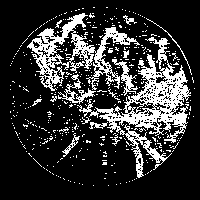

TP = 0.796325
FP = 0.0
FN = 0.203675
TN = 0.0
Trafność: 
0.796325
Czułość: 
0.796325
Swoistość: 
1.0


,Actually - Positive,Actually - Negative,Sum
My Results,,,
Positive,31853,0,31853
Negative,8147,0,8147
Sum,40000,0,40000


In [105]:
###### IMAGE 1 #####
ynew = create_image(model, df_image1, df_image1_X)

image_res = resize_to_white_black(ynew)
show_image(image_res)

TP, TN, FP, FN = count_quality(image_res, expert1)
show_properties(TP, TN, FP, FN)
confusion_matrix1 = confusion_matrix(TP, TN, FP, FN)
confusion_matrix1

In [106]:
####### IMAGE 2 ###############
df_image1 = create_dataframe(image1, expert1, cols)
df_image1

X_cols = ["Pixel value", "Mean for square", "Max value for square", "Min value for square", "Variance",
               "Third central moment"]
               
df_image1_X = df_image1[X_cols]
df_image1_X

,Pixel value,Mean for square,Max value for square,Min value for square,Variance,Third central moment
0,255.0,255.0,255.0,255.0,0.0,0.0
1,255.0,255.0,255.0,255.0,0.0,0.0
2,255.0,255.0,255.0,255.0,0.0,0.0
3,255.0,255.0,255.0,255.0,0.0,0.0
4,255.0,255.0,255.0,255.0,0.0,0.0
...,...,...,...,...,...,...
39995,255.0,255.0,255.0,255.0,0.0,0.0
39996,255.0,255.0,255.0,255.0,0.0,0.0
39997,255.0,255.0,255.0,255.0,0.0,0.0
39998,255.0,255.0,255.0,255.0,0.0,0.0


In [0]:
ynew = create_image(model, df_image1, df_image1_X)

image_res = resize_to_white_black(ynew)
show_image(image_res)

TP, TN, FP, FN = count_quality(image_res, expert1)
show_properties(TP, TN, FP, FN)
confusion_matrix1 = confusion_matrix(TP, TN, FP, FN)
confusion_matrix1